# Practical course Computer Vision

- Clabault Tom
- Magnin Constantin
- Ruivo Bastien
- Spataro Mathis

In [9]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [10]:
def find_pattern_ZeroMeanCorr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_zmc = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width] - np.mean(im[y:y + template_height, x:x + template_width])
            template = template
            zmc = np.sum(regionOfInterest * template)
            if zmc >= max_zmc:
                max_zmc = zmc
                x_max = x
                y_max = y
    return x_max, y_max

def find_pattern_SumSquaredDist(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    least_ssd = math.inf
    x_min = -1
    y_min = -1
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            roi = im[y:y + template_height, x:x + template_width]
            ssd = np.sum((roi - template) **2)
            if ssd < least_ssd:
                least_ssd = ssd
                x_min = x
                y_min = y
    return x_min, y_min

def find_pattern_NormCrossCorr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_ncc = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width] - np.mean(im[y:y + template_height, x:x + template_width])
            template = template - np.mean(template)
            ncc = np.sum(regionOfInterest * template) / np.sqrt(np.sum(regionOfInterest ** 2) * np.sum(template ** 2))
            if ncc >= max_ncc:
                max_ncc = ncc
                x_max = x
                y_max = y
    return x_max, y_max

def find_pattern_Corr(im, template):
    im_width = im.shape[1]
    im_height = im.shape[0]
    template_width = template.shape[1]
    template_height = template.shape[0]
    max_corr = -math.inf
    x_max = 0
    y_max = 0
    for y in range(0, im_height - template_height + 1):
        for x in range(0, im_width - template_width + 1):
            regionOfInterest = im[y:y + template_height, x:x + template_width]
            corr = np.sum(regionOfInterest * template)
            if corr >= max_corr:
                max_corr = corr
                x_max = x
                y_max = y
    return x_max, y_max

def rgb2gray_numpy(rgb_img):
    return np.dot(rgb_img[...,:3], [0.2989, 0.5870, 0.1140])

def test(input_image, template):
    window_size = template.shape
    y = np.lib.stride_tricks.as_strided(input_image,
                    shape=(input_image.shape[0] - window_size[0] + 1,
                           input_image.shape[1] - window_size[1] + 1,) +
                          window_size,
                    strides=input_image.strides * 2)
    ssd = np.einsum('ijkl,kl->ij', y, template)
    ssd *= - 2
    ssd += np.einsum('ijkl, ijkl->ij', y, y)
    ssd += np.einsum('ij, ij', template, template)

    return np.unravel_index(np.argmin(ssd), ssd.shape)

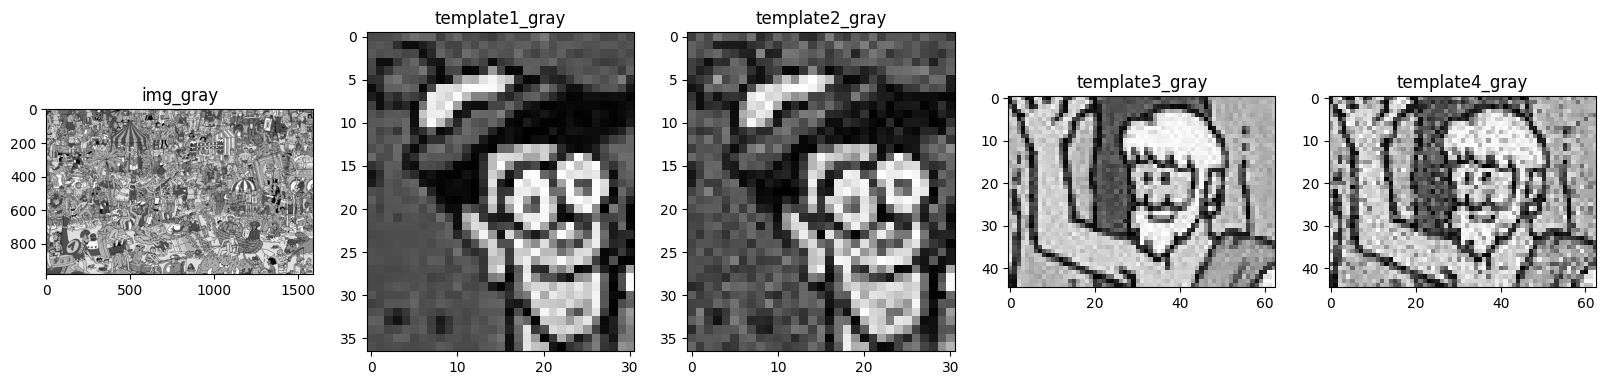

In [11]:
# Variables globales
# read it to a numpy array
img = cv.imread('data/where_is_waldo.jpg')
template1 = cv.imread('data/template1.png')
template2 = cv.imread('data/template2.png')
template3 = cv.imread('data/template3.jpg')
template4 = cv.imread('data/template4.jpg')

img_gray = rgb2gray_numpy(img)
template1_gray = rgb2gray_numpy(template1)
template2_gray = rgb2gray_numpy(template2)
template3_gray = rgb2gray_numpy(template3)
template4_gray = rgb2gray_numpy(template4)

# show img gray, and all templates
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(img_gray, cmap='gray')
ax.set_title('img_gray')
ax = fig.add_subplot(1, 5, 2)
ax.imshow(template1_gray, cmap='gray')
ax.set_title('template1_gray')
ax = fig.add_subplot(1, 5, 3)
ax.imshow(template2_gray, cmap='gray')
ax.set_title('template2_gray')
ax = fig.add_subplot(1, 5, 4)
ax.imshow(template3_gray, cmap='gray')
ax.set_title('template3_gray')
ax = fig.add_subplot(1, 5, 5)
ax.imshow(template4_gray, cmap='gray')
ax.set_title('template4_gray')



plt.show()


def test_metric(im, templates, func) :
    fig = plt.figure(figsize=(20, 20))
    id = 1
    for i in templates:
        x, y = func(im, i)
        res = im.copy()
        cv.line(res, (x, y), (x + i.shape[1], y), (0, 0, 255), 5)
        cv.line(res, (x, y), (x, y + i.shape[0]), (0, 0, 255), 5)
        cv.line(res, (x + i.shape[1], y), (x + i.shape[1], y + i.shape[0]), (0, 0, 255), 5)
        cv.line(res, (x, y + i.shape[0]), (x + i.shape[1], y + i.shape[0]), (0, 0, 255), 5)
        ax = fig.add_subplot(1, len(templates), id)
        ax.imshow(res, cmap='gray')
        ax.set_title('x: ' + str(x) + ' y: ' + str(y))
        id += 1
    plt.show()

# https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html


# Pattern matching

## What did we do 

We used the waldo dataset to find waldo in a picture, for this we used the following steps:
- iterate over the image
- for each pixel, get a region of interest (ROI) of waldo template size
- compute the corresponding metric between the ROI and the template and store it
- return the location of the ROI with the lowest metric

At first, we tried the sum of squared distances, but it didn't work as you can see in the following images because we loaded the images with matplotlib, which altered the image too much to be recognized by SSD, the problem was fixed in this notebook, that's what we tried multiple metrics, see below.

### Sum of squared distances

It is defined by $SSD(x,y) = \sum (roi_{xy} - template)^2$
- Where ROI stands for "Region of Interest" at x y, which is a region the size of our template taken in our image.
- Template is the image we try to find in the target image.

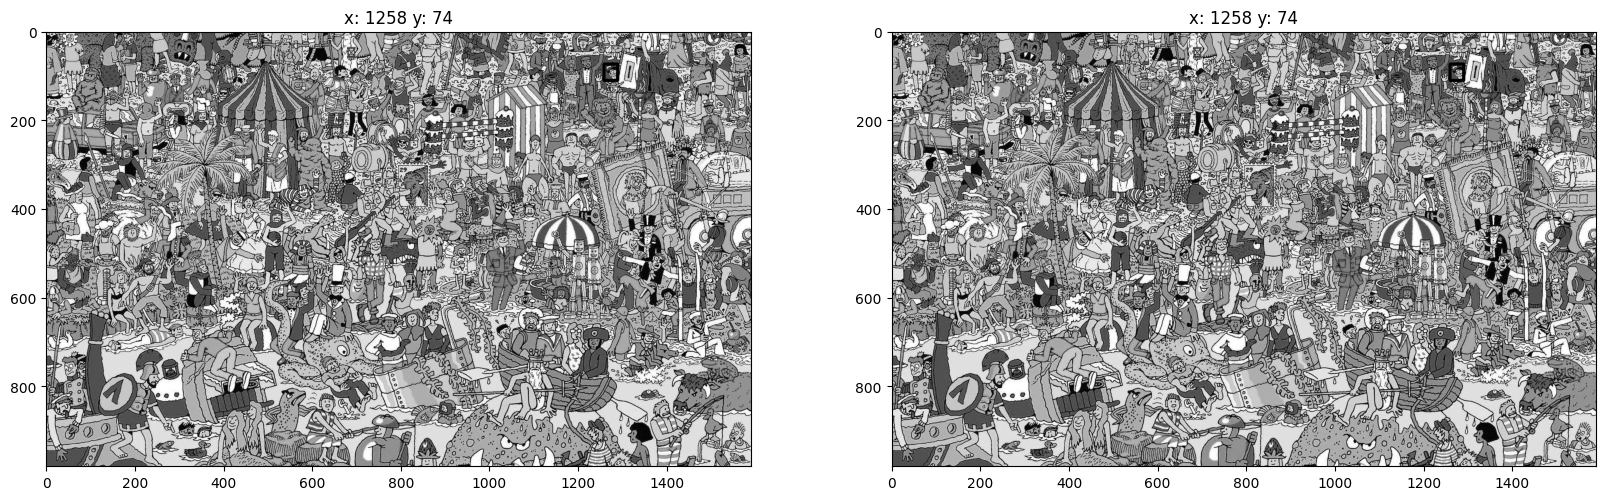

In [12]:
# time correlation
templates = [template1_gray, template2_gray]
test_metric(img_gray, templates, find_pattern_SumSquaredDist)

- It's able to find waldo in this case, so it's a good metric to use for pattern matching images that are fix. 
- But it is important to note that SSD is sensitive to change in luminance and size of the image, that is why we got problem when we load the image with matplotlib. The image was modified and we were unable to find the pattern, unlike with NCC and ZMC, but in exchange it's less computing expansive than NCC and ZMC.

### Normalized cross correlation
It is defined by $NCC(x, y) = \frac{\sum (ROI - average(ROI)) \times (template - average(template))}{\sqrt{\sum (ROI - average(ROI))^2 \times \sum (template - average(template))^2}}$

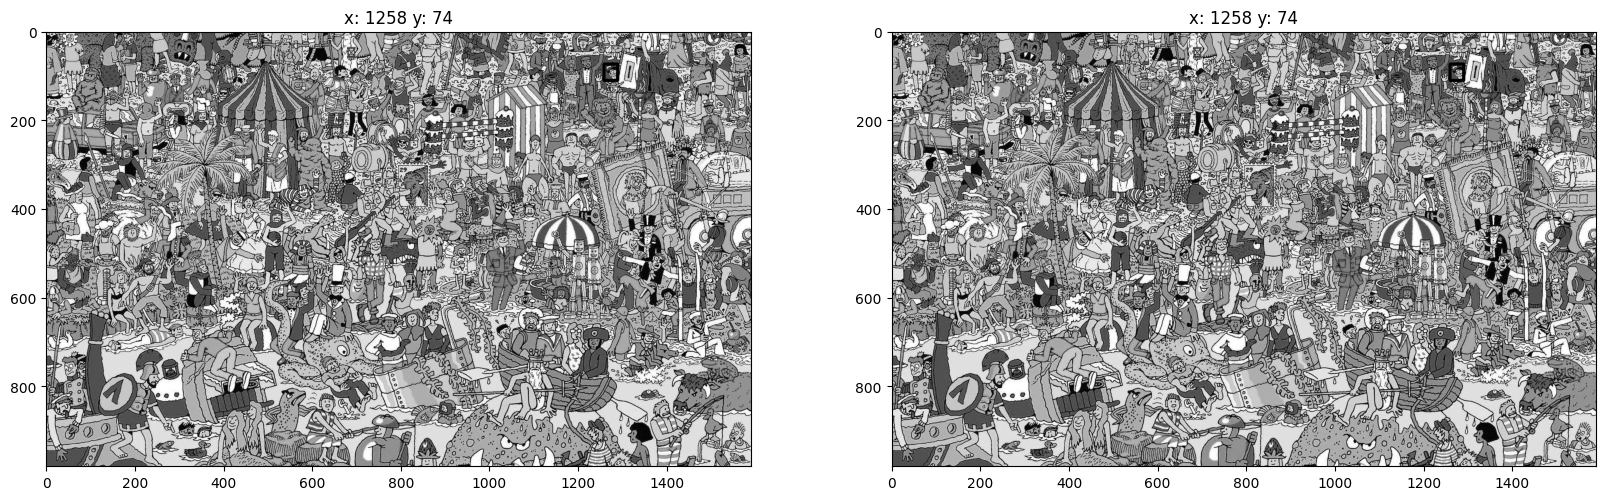

In [13]:
test_metric(img_gray, templates, find_pattern_NormCrossCorr)

- It's able to find waldo, with and without noises so it's a good metric to use but it's painfully slow as we can imagine due to all the division, this is a solution to keep in mind. But in simple case, it's easier to start with SSD. And if it's missing the template too many times, we can try this metric.

### Correlation

It is defined as follow  $C(x, y) = \sum ROI \times Template$

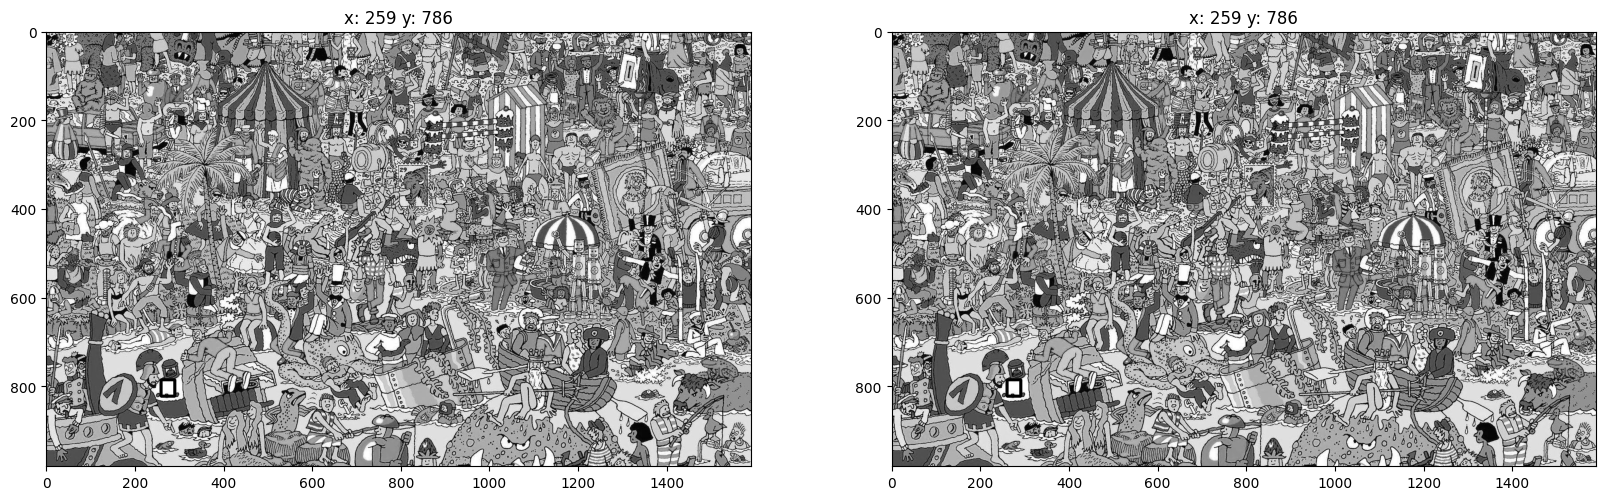

In [14]:
test_metric(img_gray, templates, find_pattern_Corr)

- It's not able to find waldo, it's too sensitive to the background / and noise that we may find in the image but it's faster than the normalized cross correlation and SSD. However, and as we can see in the formula if we interpreted it correctly from the course, the more higher the value of the ROI is, the more higher it will be and that's why the program find a white roi as the best candidate. I don't know if this metric is really suitable for founding a pattern.

### Zero mean correlation

It is defined as follow $ZMC = \sum (ROI - average(ROI)) \times Template$

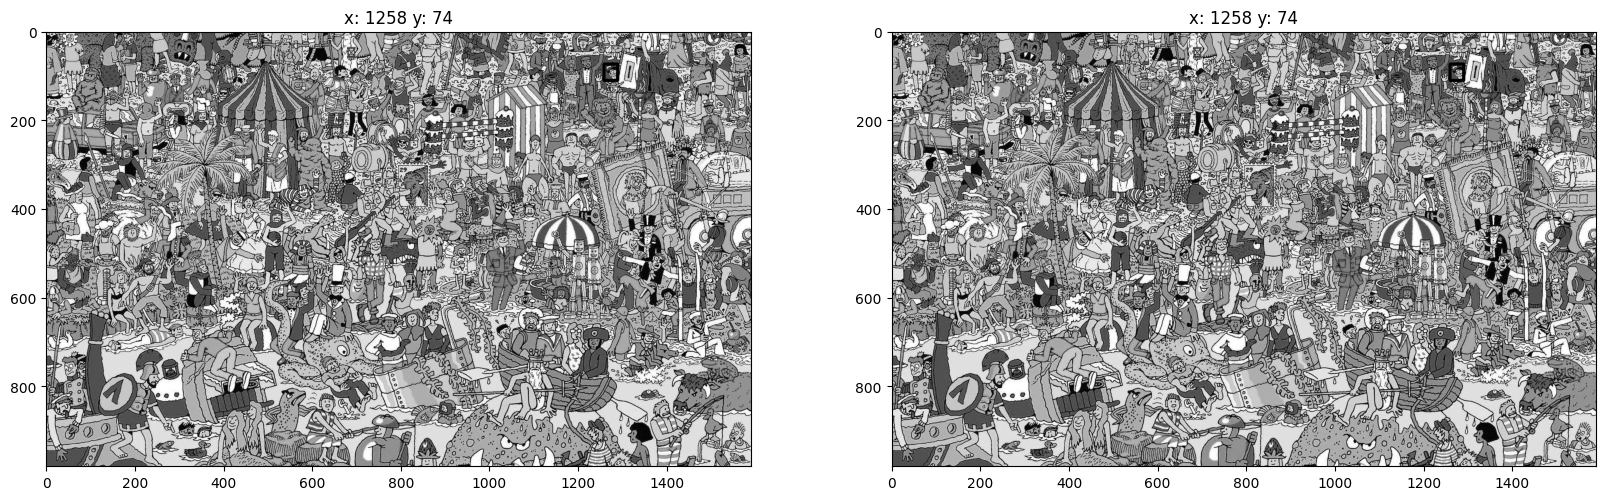

In [15]:
test_metric(img_gray, templates, find_pattern_ZeroMeanCorr)

- It's able to find waldo, with and without noises so it's a good metric to use and it's faster than the normalized cross correlation, however it is known to make false detection in other case and it is slower than SSD.

## Benchmark

In [16]:
DO_BENCHMARK = 1 #Mettre a 0 pour éviter de run les benchmarks a chaque fois qu'on "run all" les cellules

if (DO_BENCHMARK):
    #functionsToBenchmark = [find_pattern_Corr, find_pattern_ZeroMeanCorr, find_pattern_NormCrossCorr, find_pattern_SumSquaredDist]
    functionsToBenchmark = {"find_pattern_Corr" : find_pattern_Corr, "find_pattern_ZeroMeanCorr": find_pattern_ZeroMeanCorr, "find_pattern_NormCrossCorr" : find_pattern_NormCrossCorr, "find_pattern_SumSquaredDist": find_pattern_SumSquaredDist}

    ITERATIONS = 10

    print("-----------------------")
    print("------ Grayscale ------")
    print("-----------------------")
    for functionName in functionsToBenchmark:
        function = functionsToBenchmark[functionName]

        print("Time for " + functionName + ": ", end='')
        print(timeit.timeit(lambda: function(img_gray, template1_gray), number=ITERATIONS) / ITERATIONS, end='')
        print("s per iteration")





    print()
    print()
    print("-----------------------")
    print("--------- RGB ---------")
    print("-----------------------")
    for functionName in functionsToBenchmark:
        function = functionsToBenchmark[functionName]

        print("Time for " + functionName + ": ", end='')
        print(timeit.timeit(lambda: function(img, template1), number=ITERATIONS) / ITERATIONS, end='')
        print("s per iteration")

-----------------------
------ Grayscale ------
-----------------------
Time for find_pattern_Corr: 5.420857424900168s per iteration
Time for find_pattern_ZeroMeanCorr: 15.267262754500189s per iteration
Time for find_pattern_NormCrossCorr: 33.68204152429971s per iteration
Time for find_pattern_SumSquaredDist: 7.548036304599736s per iteration


-----------------------
--------- RGB ---------
-----------------------
Time for find_pattern_Corr: 8.567348977800066s per iteration
Time for find_pattern_ZeroMeanCorr: 24.510718908499985s per iteration
Time for find_pattern_NormCrossCorr: 49.98489026099996s per iteration
Time for find_pattern_SumSquaredDist: 10.864691014100027s per iteration


# Benchmarks

Because several methods are able to find Waldo (noisy template or not), the deciding factor here will be the time it takes
to compute the operation on the "Where is Waldo" image that we're using.

Here are the timings that we measured for the search of the template in the entire image

## Grayscale Waldo template
- Simple Correlation: 13.9s average. Not able to find Waldo
- Zero Mean Correlation: 30.19s average. Able to find Waldo
- Normalized Cross Correlation: 70.99s average. Able to find Waldo
- Sum of squared distances: 16.09s average. Able to find Waldo.

## RGB Waldo template
- Simple Correlation: 17.99s average. Not able to find Waldo
- Zero Mean Correlation: 36.77s average. Able to find Waldo
- Normalized Cross Correlation: 88.94s average. Able to find Waldo
- Sum of squared distances: 19.61s average. Able to find Waldo.

All in all, the best method to find the template in this exact scenario is going to be the Sum of squared distance because it's the fastest method that can find Waldo (the simple correlation is slightly faster but it cannot find the template so it's of no use here).

Using an RGB template instead of a grayscale doesn't result in any significant improvement when it comes to finding Waldo. However, doing the computations in RGB rather than grayscale results in an 20% to 30% slowdown so there's really no point to searching the template in RGB here (even though it could yield better results for other applications).

In [17]:
def homoMatrix(src, dst):
        nbp = src.shape[0]
        A = np.zeros((nbp*2, 8))
        B = np.zeros((nbp*2, 1))
        for i in range(src.shape[0]):
            xs, ys = src[i]
            xd, yd = dst[i]
            A[i * 2] = [xs, ys, 1, 0, 0, 0, (-xd)*xs, (-xd)*ys]
            A[i * 2 + 1] = [0, 0, 0, xs, ys, 1, (-yd)*xs, (-yd)*ys]
            B[i * 2] = xd
            B[i * 2 + 1] = yd
        h = np.linalg.lstsq(A, B, rcond=None)[0]
        h = np.append(h, 1)
        h = h.reshape((3, 3))
        return h

def warpDestToSrc(imgSrc, imgDst, src, dst, use_bbox = True):
    h = homoMatrix(src, dst)
    res = imgDst.copy()
    h_inv = np.linalg.inv(h)

    if(use_bbox):
        min_x = np.min(dst[:, 0])
        max_x = np.max(dst[:, 0])
        min_y = np.min(dst[:, 1])
        max_y = np.max(dst[:, 1])
    else:
        min_x = 0
        max_x = imgDst.shape[1]
        min_y = 0
        max_y = imgDst.shape[0]
    
    min = (min_x, min_y)
    max = (max_x, max_y)

    for y in range(min[1], max[1]):
        for x in range(min[0], max[0]):
            p = np.array([x, y, 1])
            p = np.dot(h_inv, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgSrc.shape[1] and p[1] >= 0 and p[1] < imgSrc.shape[0]:
                res[y, x] = imgSrc[int(p[1]), int(p[0])]
                #upscale factor
    return res
    

def warpSrcToDest(imgSrc, imgDst, src, dst):
    h = homoMatrix(src, dst)
    res = imgDst.copy()
    for y in range(imgSrc.shape[0]):
        for x in range(imgSrc.shape[1]):
            # found the corresponding point in the destination image
            p = np.array([x, y, 1])
            p = np.dot(h, p)
            p = p / p[2]
            if p[0] >= 0 and p[0] < imgDst.shape[1] and p[1] >= 0 and p[1] < imgDst.shape[0]:
                cx = int(p[0])
                cy = int(p[1])
                res[cy, cx] = imgSrc[y, x]
    return res

# Image transformation

For image transformation, we first took with hand for point on the bus, and then we built the homography matrix.

## Homography matrix construction

- This matrix consist of finding the transformation applied to the src points to become dst points
- We define the probleme as a linear algebra system based on the matrix equation $Ax = b$
    - We have x, which is the position in the source image (the simpson poster) and b (the position in the bus)
    - The objective is to find A, the matrix to multiply by when we will iterate from pixel to pixel.
        - We build the system with two rows for each point, like 
            - $r_{i} = [x_{si}, y_{si}, 1, 0, 0, 0, -x_{si} \times x_{di}, -y_{si} \times x_{di}]$
            - $r_{i+1} = [0, 0, 0, x_{si}, y_{si}, 1, -x_{si} \times y_{di}, -y_{si} \times y_{di}]$
        - s stands for source and d for destination.


In [18]:
bus = image.imread('data/bus.jpg')

dstlt = (583, 209)
dstrt = (797, 229)
dstbl = (594, 517)
dstbr = (808, 466)

# dstlt = (1229, 1264)
# dstrt = (1940, 1274)
# dstbl = (1274, 2344)
# dstbr = (1983, 2289)

dst = np.array([dstlt, dstrt, dstbl, dstbr])

poster = image.imread('data/ryan.jpg')

srclt = (0, 0)
srctr = (poster.shape[1], 0)
srcbl = (0, poster.shape[0])
srcbr = (poster.shape[1], poster.shape[0])

src = np.array([srclt, srctr, srcbl, srcbr])

## Warping

There is two types of warping, the first one is iterating on the pixel of the source image, and put them into the destination image (from simpson to bus)
It is faster in this case, but depending on which image is bigger, it can be faster to iterate on the source, or on the destination.

It is important to note that pixel does not always have a corresponding 1 to 1 pixel, so we have to interpolate the value of the pixel, which is not done in this case and lead to holes on the image, it should be the next step if we dig further into image transformation.

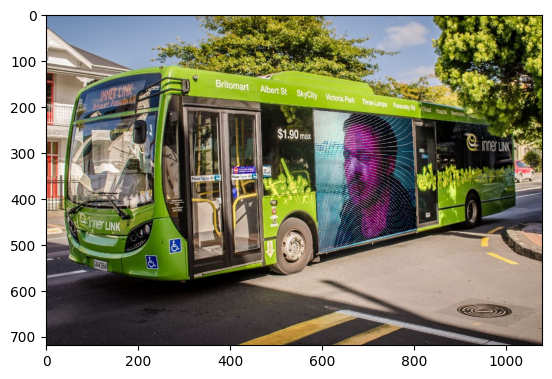

In [19]:
res = warpSrcToDest(poster, bus, src, dst)

plt.imshow(res)
plt.show()

The second one, is to iterate on the destination image, and find the corresponding pixel in the source image, and put it into the destination image. It requiere to compute the inverse of the homography matrix, and it is slower in this case, but there is no hole in the image.

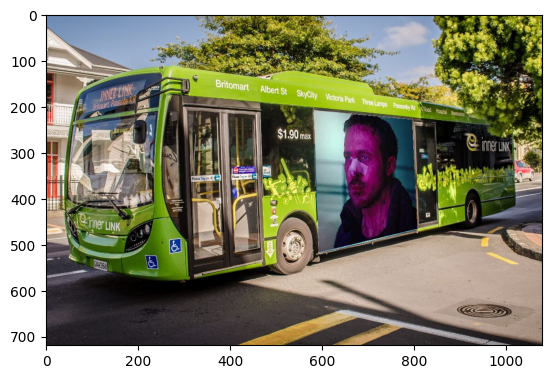

In [20]:
res = warpDestToSrc(poster, bus, src, dst, True)

plt.imshow(res)
plt.show()

# Image Stitching

## Steps
Given several images that were taken with a slightly different point of view (rotation to the left or to the right, in a panorama fashion), the goal is to stich the images together to reconstruct the panorama. We're going to process images two by two (and not all at the same time), stitching the second image to the first, and then the third to the result of the previous step, and then fourth to the result, ....
To do that, several steps are needed:

- Firstly we need to find features in the two images that we want to stitch. 
- Secondly, we need to match the features of the two images i.e. identity what are the common features of both images and find where these common features are on each of the images
- Thirdly we need to evaluate the transformation needed to go from the set of features of the first image to the set of features of the second image
- Lastly, we need to stitch the two images using the previously found transformation

In [21]:
def extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2):
    mp_src = []
    mp_dst = []
    for i in matched_points:
        mp_src.append((key_points_img1[i.queryIdx].pt[0], key_points_img1[i.queryIdx].pt[1]))
        mp_dst.append((key_points_img2[i.trainIdx].pt[0], key_points_img2[i.trainIdx].pt[1]))

    mp_src = np.array(mp_src)
    mp_dst = np.array(mp_dst)

    return mp_src, mp_dst

def find_features_ORB_between_images(img1, img2):
    orb_feature_detector = cv.ORB_create()

    key_points_img1, descriptors_1 = orb_feature_detector.detectAndCompute(img1, None)
    key_points_img2, descriptors_2 = orb_feature_detector.detectAndCompute(img2, None)

    # Creation du matcher qui va associer les matchs des deux images
    #Brute force matcher avec le Norme de Hamming
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matched_points = bf.match(descriptors_1, descriptors_2)


    #img3 = cv.drawMatches(img1, key_points_img1, img2, key_points_img2, matched_points[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.imshow(img3),plt.show()

    mp_src, mp_dst = extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2)
    return mp_src, mp_dst    

def find_features_SIFT_between_images(img1, img2):
    SIFT_detector = cv.SIFT_create()

    key_points_img1, descriptors_1 = SIFT_detector.detectAndCompute(img1, None)
    key_points_img2, descriptors_2 = SIFT_detector.detectAndCompute(img2, None)

    # Creation du matcher qui va associer les matchs des deux images
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck = True)
    matched_points = bf.match(descriptors_1, descriptors_2)


    #img3 = cv.drawMatches(img1, key_points_img1, img2, key_points_img2, matched_points[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.imshow(img3),plt.show()

    mp_src, mp_dst = extract_key_points_coordinates_from_matches(matched_points, key_points_img1, key_points_img2)
    return mp_src, mp_dst

## Feature searching
To find features in a given image, multiple methods are available. We've tried both the SIFT and ORB algorithms which are both feature detectors and descriptors.

## Feature matching
Once features have been found on both the images that we want to stitch, we need to find which feature of the first image corresponds to which features on the second image. This is done by computing a distance between the descriptors of the features. The distance function depends on the format of the descriptors so the L2 norm is used to compute the distance between SIFT descriptors whereas the Hamming distance is used to compute the distance between ORB (BRIEF) descriptors.

Doing so, we can find, for each feature descriptor of the first image, the feature descriptor (and hence the feature point) on the second image that best matches it. This gives us pairs of points that will be used to estimate the transformation needed between the two images.

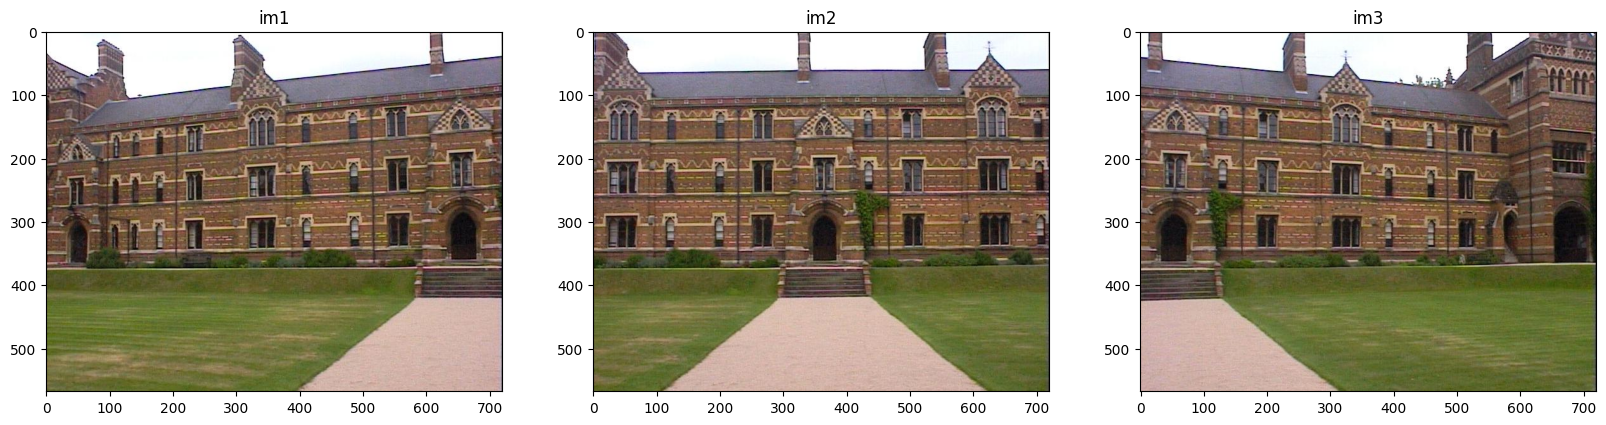

In [22]:
images = []
# fill in order of image taken
images.append(image.imread('data/keble_a.jpg'))
images.append(image.imread('data/keble_b.jpg'))
images.append(image.imread('data/keble_c.jpg'))

# plot images
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(images[0])
ax.set_title('im1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(images[1])
ax.set_title('im2')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(images[2])
ax.set_title('im3')
plt.show()

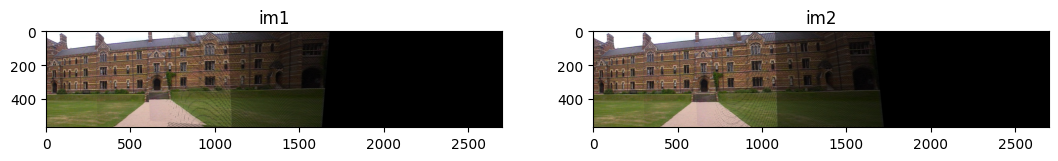

In [23]:
# src, dst = find_features_SIFT_between_images(im1, im2)

src = np.asarray([[0, 0], [0, 10], [10, 0], [10, 10]])
src_homo = np.asarray([[0, 0, 1], [0, 10, 1], [10, 0, 1], [10, 10, 1]])
dst = np.asarray([[1, 1], [1, 11], [11, 1], [11, 11]])

h = homoMatrix(src, dst)

def toHomogeneous2D(vec3):
    x = vec3[0]/vec3[2]
    y = vec3[1]/vec3[2]
    return x, y

def stitch_images(images, feature_find_function):
    image_out = np.zeros((int(images[0].shape[0]), int(images[0].shape[1] * 3 * 1.25), 3), dtype=int)

    start_img = images[0]
    image_out[0:start_img.shape[0], 0:start_img.shape[1]] = start_img.copy()

    for i in range(len(images) - 1):
        img1 = image_out.astype('uint8')
        img2 = images[i + 1]

        feature_points_im1, feature_points_im2 = feature_find_function(img1, img2)
        hom, status = cv.findHomography(feature_points_im2, feature_points_im1, cv.RANSAC)
        
        h = np.asarray(hom)

        #Transforms the second image into the first image coordinates frame
        # Create a 2D grid of x, y coordinates
        x = np.arange(img2.shape[1])
        y = np.arange(img2.shape[0])

        # Use NumPy's meshgrid function to create coordinate grids
        xx, yy = np.meshgrid(x, y)
        zz = np.ones(xx.shape[0] * xx.shape[1])

        # Stack the coordinates to create a 1D array of (x, y) pairs
        coordinates = np.vstack((xx.ravel(), yy.ravel(), zz)).T
        transformed_coordinates = coordinates.dot(h.T)
        transformed_coordinates = np.asarray([(int(a/c), int(b/c)) for (a, b, c) in transformed_coordinates])

        img2_width = img2.shape[1]
        for y in range(img2.shape[0]):
            for x in range(img2_width):
                transformed_y = transformed_coordinates[y * img2_width + x][1]
                transformed_x = transformed_coordinates[y * img2_width + x][0]

                destination_coord_x = transformed_x
                destination_coord_y = transformed_y

                if 0 < destination_coord_x < image_out.shape[1] and 0 < destination_coord_y < image_out.shape[0]:
                    image_out[destination_coord_y, destination_coord_x] = img2[y, x]
    
    return image_out

stitched_image_ORB = stitch_images(images, find_features_ORB_between_images)
stitched_image_SIFT = stitch_images(images, find_features_SIFT_between_images)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(stitched_image_ORB)
ax.set_title('im1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(stitched_image_SIFT)
ax.set_title('im2')
plt.show()

## Transformation (warping)
Once the matching feature points have been found between the two images, we can estimate an homography trasnformation matrix to go from the second image to the first image, "pasting" the second image onto the first image, effectively stitching the two images together.

This transformation can be estimated either by choosing 4 points on the image and solving the regular linear system of equation to find the homography matrix or by using an algorithm such as RANSAC. 
Using RANSAC is the approach that we have chosen.
RANSAC functions by selecting, at random several feature points between the two images. It then constructs an homography matrix using only the points selected at the previous step. The transformation matrix thus constructed is then tested against all the other feature points of the images. If points from image 2 are correctly transformed to their equivalent (found during the feature matching step) on the image 1, then this means that the transformation matrix is correct.
RANSAC thus proceeds iteratively to find the best transformation matrix between the two set of points, putting aside outliers.

The transformation matrix estimated by RANSAC is then used to warp all the points of the second image onto the first image. This has for effect to make corresponding features meet and this effectively stitches the images.

## Limitations

There are one main limitation to our current implementation: the difference of image sizes after they have been warped. This poses a problem when warping an image results in an image that is larger than it originally was. Indeed, when warping the image enlarges it, the destination space is bigger than the starting space. This results in empty spaces between the pixels of the warped image. Effectively, this creates black(or whatever the background color is) lines in the warped image as can be seen on the figure of the above cell. One solution to this problem could be interpolating the values of adjacent pixels to fill in the blanks but we haven't implemented this solution.